In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

# Práctico 05: Aprendizaje No Supervisado

Algunos links que voy viendo: 
- https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086 y la notebook que compartió Santi
- https://bpostance.github.io/posts/clustering-mixed-data/. Muy bueno, llegué hasta el 3.2.2.
- un paper teorico: https://arxiv.org/pdf/1811.04364.pdf#:~:text=Clustering%20is%20often%20applied%20to,feature%20values%20of%20these%20datasets.
- No vi aun: https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad

Realizaremos estudios de segmentación de clientes. Para ello utilizaremos varios métodos de clustering como K-means y DBSCAN ¿Podemos agrupar a clientes propensos a adquirir un plazo fijo? ¿Bajo qué características pueden agruparse esos clientes?

## Práctico 05: Aprendizaje Supervisado - Resolución

In [4]:
# Leemos el dataset original
df = pd.read_csv("https://raw.githubusercontent.com/AgusCarchano/Mentorias-grupo1/master/data/bank-additional-full.csv", sep=";")

In [5]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
# Leer el data set que obtuvimos a partir del análisis y curación de los datos que realizamos en el Práctico 2
df_pp=pd.read_csv("/content/bank_preprocessed_df.csv", sep=",")
#desde el repo
### df_pp=pd.read_csv("https://github.com/AgusCarchano/Mentorias-grupo1/blob/master/data/bank_preprocessed_df.csv", sep=",")

In [8]:
df_pp.head(2)

,id,age,job,marital,education,housing,loan,contact,campaign,previous,poutcome,cons.conf.idx,euribor3m,y,job_groups,education_groups
0,0,56,housemaid,married,basic.4y,0,0,telephone,1,0,nonexistent,-36.4,4.857,0,Sin ingreso Propio,Basic or less
1,1,57,services,married,high.school,0,0,telephone,1,0,nonexistent,-36.4,4.857,0,Servicios,High School


### Exploración de variables interesantes

Las variables más relevantes para identificar clusters de clientes deberían ser aquellas que representen características personales de los clientes, las cuales puedan ser asociadas luego a una mayor o menor probabilidad de contratar un Plazo Fijo.

En tal sentido, podríamos enfocar el análisis en las siguientes:
- "job"
- "marital"
- "education"
- "default"
- "housing"
- "loan"

O aquellas referidas a la manera y cantidad de veces que fue contactado por campañas de marketing:
- "campaing"
- "previous"
- "poutcome"


### Preprocesamiento

En los análisis preliminares también advertimos que la variable Campaing presenta outliers, los cuales podrían afectar significativamente el análisis de clusters que aquí se procura realizar. Por tanto, los mismo serán eliminados tomando los mismos criterios que se tomaron anteriormente.

Debido a los análisis presentados anteriormente, se tomó la definición de dejar de lado las siguientes variables: 
- Duration. Dado que solo se conoce luego de que finalice la llamada al cliente, y por ende está muy asociada a la decisión de contratar o no el PF.
- Pdays. Debido a inconsistencia y falta de datos.
- Default. Debido al alto porcentaje de datos faltantes que presenta.

In [9]:
#Eliminamos los outliers de Campaign:
q975_campaign=df.campaign.quantile(0.975)
df.drop(df[df.campaign >= q975_campaign].index, inplace = True)

Las variables a emplear para el análisis de clúster necesitan cumplir con ciertas características, por lo cual en algunos casos será necesario hacer un pre-procesamiento.

Dado que en el Práctico 2 ya habíamos realizado un análisis y curación de los datos, partiremos del conjunto de datos que obtuvimos como resultado en tal ocasión para realizar los análisis de clusters. Dado que también habíamos realizado la eliminación de outliers de la variable campaign, ambos datasets tienen la misma cantidad de observaciones, mientras que las categorías desconocido de las variables categóricas se encuentra imputada en df_pp así como también agregamos variables reduciendo la dimensionalidad de las variables categóricas.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40094 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             40094 non-null  int64  
 1   job             40094 non-null  object 
 2   marital         40094 non-null  object 
 3   education       40094 non-null  object 
 4   default         40094 non-null  object 
 5   housing         40094 non-null  object 
 6   loan            40094 non-null  object 
 7   contact         40094 non-null  object 
 8   month           40094 non-null  object 
 9   day_of_week     40094 non-null  object 
 10  duration        40094 non-null  int64  
 11  campaign        40094 non-null  int64  
 12  pdays           40094 non-null  int64  
 13  previous        40094 non-null  int64  
 14  poutcome        40094 non-null  object 
 15  emp.var.rate    40094 non-null  float64
 16  cons.price.idx  40094 non-null  float64
 17  cons.conf.idx   40094 non-null 

In [11]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40094 entries, 0 to 40093
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40094 non-null  int64  
 1   age               40094 non-null  int64  
 2   job               40094 non-null  object 
 3   marital           40094 non-null  object 
 4   education         40094 non-null  object 
 5   housing           40094 non-null  int64  
 6   loan              40094 non-null  int64  
 7   contact           40094 non-null  object 
 8   campaign          40094 non-null  int64  
 9   previous          40094 non-null  int64  
 10  poutcome          40094 non-null  object 
 11  cons.conf.idx     40094 non-null  float64
 12  euribor3m         40094 non-null  float64
 13  y                 40094 non-null  int64  
 14  job_groups        40094 non-null  object 
 15  education_groups  40094 non-null  object 
dtypes: float64(2), int64(7), object(7)
memor

Vamos a incluir la categorización de la variable edad que empleamos en el Práctico 1, como alternativa para realizar análisis de cluster exclusivamente con variables categóricas.

In [12]:
def to_categorical(column, bin_size=10, min_cut=15, max_cut=65):
    if min_cut is None:
        min_cut = int(round(column.min())) - 1
    value_max = int(np.ceil(column.max()))
    max_cut = min(max_cut, value_max)
    intervals = [(x, x + bin_size) for x in np.arange(min_cut, max_cut, bin_size)]
    if max_cut != value_max:
        intervals.append((max_cut, value_max))
    return pd.cut(column, pd.IntervalIndex.from_tuples(intervals))

In [13]:
df_pp['age_groups'] = to_categorical(df_pp.age,bin_size=10, min_cut=15, max_cut=65)

#### Pre-procesamiento previo al análisis de clústers

Tipos de variables con las que contamos para realizar los análisis de clústers

In [15]:
variables_categoricas = ['job', 'marital','housing', 'education', 'loan','contact','poutcome','month', 'day_of_week']  #Si usamos df
variables_categoricas_pp = ['job', 'marital','housing', 'education', 'loan','contact','poutcome','job_groups', 'education_groups', 'age_groups']  #Si usamos df_pp
variables_categoricas_ordinales = ['education','education_groups'] #podríamos en algún caso analizar education como ordinal
variables_numericas = ['age', 'campaign','previous','euribor3m','cons.conf.idx']

**Alternativa de pre-procesamiento sin pipelines**

In [16]:
#Transformaciones sobre variables numéricas
scaler = StandardScaler()      #Puede ser este u otro
scaler.fit(df_pp[variables_numericas])
numerical_data = scaler.transform(df_pp[variables_numericas])
numerical_data = pd.DataFrame(numerical_data,index=df_pp.index,columns=variables_numericas)
numerical_data[:2]

,age,campaign,previous,euribor3m,cons.conf.idx
0,1.530865,-0.758527,-0.354236,0.725856,0.881389
1,1.626640,-0.758527,-0.354236,0.725856,0.881389


In [17]:
#Transformaciones sobre variables categóricas
onehot=OneHotEncoder(sparse=False)
onehot.fit(df_pp[variables_categoricas_pp])
categorical_data = onehot.transform(df_pp[variables_categoricas_pp])
variable_names=onehot.get_feature_names(variables_categoricas_pp)
categorical_data = pd.DataFrame(categorical_data,index=df_pp.index,columns=variable_names)
categorical_data[:2]

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,housing_0,housing_1,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,loan_0,loan_1,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,job_groups_Administrtivos,job_groups_Ingreso Cuenta Propia o Directivo,job_groups_Operarios,job_groups_Servicios,job_groups_Sin ingreso Propio,job_groups_Tecnicos,education_groups_Basic or less,education_groups_High School,education_groups_Professional,education_groups_University,"age_groups_(15, 25]","age_groups_(25, 35]","age_groups_(35, 45]","age_groups_(45, 55]","age_groups_(55, 65]","age_groups_(65, 98]"
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
df_pp2 = pd.concat([numerical_data,categorical_data],axis=1)
df_pp2.head(2)

,age,campaign,previous,euribor3m,cons.conf.idx,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,housing_0,housing_1,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,...,education_professional.course,education_university.degree,loan_0,loan_1,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,job_groups_Administrtivos,job_groups_Ingreso Cuenta Propia o Directivo,job_groups_Operarios,job_groups_Servicios,job_groups_Sin ingreso Propio,job_groups_Tecnicos,education_groups_Basic or less,education_groups_High School,education_groups_Professional,education_groups_University,"age_groups_(15, 25]","age_groups_(25, 35]","age_groups_(35, 45]","age_groups_(45, 55]","age_groups_(55, 65]","age_groups_(65, 98]"
0,1.530865,-0.758527,-0.354236,0.725856,0.881389,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.626640,-0.758527,-0.354236,0.725856,0.881389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
df_pp2.columns

Index(['age', 'campaign', 'previous', 'euribor3m', 'cons.conf.idx',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'housing_0', 'housing_1',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'loan_0', 'loan_1', 'contact_cellular', 'contact_telephone',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success',
       'job_groups_Administrtivos',
       'job_groups_Ingreso Cuenta Propia o Directivo', 'job_groups_Operarios',
       'job_groups_Servicios', 'job_groups_Sin ingreso Propio',
       'job_groups_Tecnicos', 'education_groups_Basic or less',
       'education_groups_High School', 'educatio

### KMeans

Aclaración: "Numerical variables only. K-means uses distance-based measurements to determine the similarity between data points. If you have categorical data, use K-modes clustering, if data is mixed, use K-prototype clustering."

https://medium.com/@evgen.ryzhkov/5-stages-of-data-preprocessing-for-k-means-clustering-b755426f9932

#### Selección de variables a clusterizar

Para complementar el análisis presentado en la notebook "Práctico_05", se realizaron algunas pruebas del método KMeans utilizando la variable edad y alguna de las variables personales (categóricas) encodeadas.

In [ ]:
#Alternativas que se fueron analizando
X=df_pp2[["age", 'marital_divorced', 'marital_married', 'marital_single']]  #3C: se forman clusters claros respecto a las variables de análisis, pero no mucha dif en prop de PF
X=df_pp2[["age", 'campaign', 'previous']]   #4C: diferencia un cluster con mayor probabilidad de contratar PF, pero no difiere mucho de otros en fc de características
X=df_pp2[["age", 'campaign']]   #3C: no diferencia mucho la proba de PF en cada cluster
X=df_pp2[["age", 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']] #4C: logra armar un cluster con proba mayor (cluster formado por los que fueron contactados en campañas previas), pero en términos de estas variables es más complejo ver la relación 
#Con las variables de jobs y education no logra identificar cuál sería el clúster optimo. Con education se puede mas o menos forzar algo, complejo

In [ ]:
#Variables a tomar para el análisis de clústers
X=df_pp2[["age",'education_groups_Basic or less',
       'education_groups_High School', 'education_groups_Professional',
       'education_groups_University']]

#### Elbow method

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

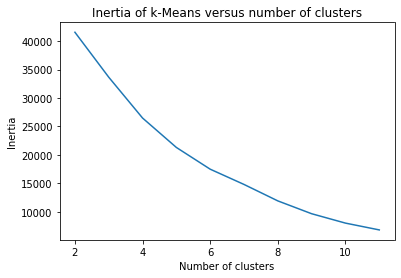

In [ ]:
# Graficar el método elbow para determinar el número de clusters
#Para elegir la cantidad de clusters que se podrían armar en base a los datos, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(X).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

A partir del análisis presentado en el gráfico anterior, se eligirían 3 cantidad de clusters a partir de los datos.

In [ ]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(X) #Solamente usando tres variables numéricas más relevantes

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  26483.673782171754


In [ ]:
df_clusters_kmeans=df_pp.copy()
df_clusters_kmeans['kmeans'] = km.labels_   #clusters

In [ ]:
df_clusters_kmeans.head(3)

,id,age,job,marital,education,housing,loan,contact,campaign,previous,poutcome,cons.conf.idx,euribor3m,y,job_groups,education_groups,age_groups,kmeans
0,0,56,housemaid,married,basic.4y,0,0,telephone,1,0,nonexistent,-36.4,4.857,0,Sin ingreso Propio,Basic or less,"(55, 65]",1
1,1,57,services,married,high.school,0,0,telephone,1,0,nonexistent,-36.4,4.857,0,Servicios,High School,"(55, 65]",1
2,2,37,services,married,high.school,1,0,telephone,1,0,nonexistent,-36.4,4.857,0,Servicios,High School,"(35, 45]",0


#### Intentar explicar los clusters

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


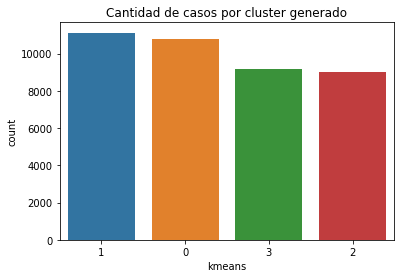

In [ ]:
sns.countplot(df_clusters_kmeans.kmeans, order=df_clusters_kmeans.kmeans.value_counts().index)
plt.title("Cantidad de casos por cluster generado")
plt.show()

In [ ]:
pd.crosstab(df_clusters_kmeans.kmeans, df_clusters_kmeans.y, normalize='index')   #no se ve una diferencia muy marcada entre la propensión a contratar PF entre los clústers encontrados

y,0,1
kmeans,,
0,0.887426,0.112574
1,0.872516,0.127484
2,0.923496,0.076504
3,0.860670,0.139330


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


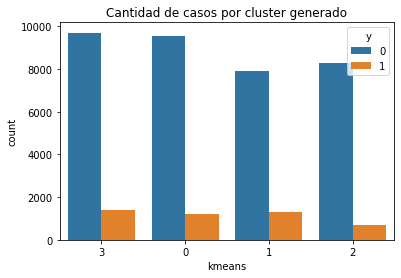

In [ ]:
sns.countplot(df_clusters_kmeans.kmeans, order=df_clusters_kmeans.kmeans.value_counts().index, hue=df_clusters_kmeans.y)
plt.title("Cantidad de casos por cluster generado")
plt.show()

In [ ]:
pd.crosstab(df_clusters_kmeans.kmeans, df_clusters_kmeans.education_groups, normalize='index')  

education_groups,Basic or less,High School,Professional,University
kmeans,,,,
0,0.000000,0.670716,0.329284,0.000000
1,0.000000,0.000000,0.000000,1.000000
2,1.000000,0.000000,0.000000,0.000000
3,0.400162,0.192394,0.167311,0.240133


In [ ]:
pd.crosstab(df_clusters_kmeans.kmeans, df_clusters_kmeans.age_groups, normalize='index')   

age_groups,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 98]"
kmeans,,,,,,
0,0.077708,0.520122,0.402170,0.000000,0.000000,0.000000
1,0.031434,0.573961,0.368827,0.025778,0.000000,0.000000
2,0.055488,0.398977,0.497943,0.047593,0.000000,0.000000
3,0.000000,0.000000,0.026432,0.659714,0.258653,0.055201


In [ ]:
pd.crosstab(df_clusters_kmeans.kmeans, df_clusters_kmeans.poutcome, normalize='index') 

poutcome,failure,nonexistent,success
kmeans,,,
0,0.114522,0.852745,0.032734
1,0.102893,0.855776,0.041331
2,0.101968,0.880574,0.017458
3,0.102400,0.854176,0.043424


Fue posible identificar grupos de clientes diferenciados, por ejemplo: 
- jóvenes de entre 25-45 años con alto nivel educativo, 
- jóvenes de entre 25-45 años con bajo nivel educativo, 
- adultos de 45 años o más con nivel educativo medio-bajo. 

No obstante, no fue posible encontrar diferencias significativas en la propensión a contratar PF entre los grupos identificados. 

#### **Pruebas con Kmodes**

In [21]:
pip install kmodes

In [22]:
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

Un método alternativo para el análisis de clusters a partir de variables categóricas, es Kmeans. Realizaremos algunas pruebas a partir de este método para ver si mejoran los resultados del análisis que obtuvimos anteriormente.

In [23]:
#variables_categoricas_pp = ['job', 'marital','housing', 'education', 'loan','contact','poutcome','job_groups', 'education_groups', 'age_groups']  #Si usamos df_pp
X=['education', 'age_groups', 'job_groups']

In [24]:
kmodes = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = kmodes.fit_predict(df_pp[X])    #Con KModes no se calcula la inertia, ver de qué manera uno podría elegir la cantidad de clústers

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10097, cost: 54946.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2478, cost: 52907.0
Run 2, iteration: 2/100, moves: 2867, cost: 52907.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3586, cost: 55192.0
Run 3, iteration: 2/100, moves: 6316, cost: 52569.0
Run 3, iteration: 3/100, moves: 5063, cost: 52569.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 53275.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4818, cost: 55504.0
Best run was number 3


In [ ]:
KModes?

In [25]:
df_clusters_kmodes=df_pp.copy()
df_clusters_kmodes['kmodes'] = kmodes.labels_   #clusters

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


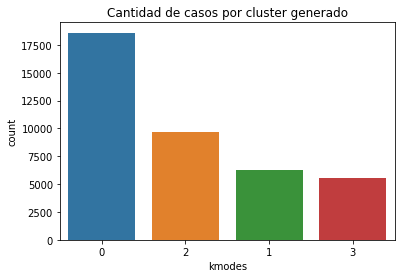

In [27]:
sns.countplot(df_clusters_kmodes.kmodes, order=df_clusters_kmodes.kmodes.value_counts().index)
plt.title("Cantidad de casos por cluster generado")
plt.show()

In [26]:
pd.crosstab(df_clusters_kmodes.kmodes, df_clusters_kmodes.y, normalize='index')   #no se ve una diferencia muy marcada entre la propensión a contratar PF entre los clústers encontrados

y,0,1
kmodes,,
0,0.872942,0.127058
1,0.883123,0.116877
2,0.885923,0.114077
3,0.927759,0.072241


In [28]:
pd.crosstab(df_clusters_kmodes.kmodes, df_clusters_kmodes.education_groups, normalize='index')  

education_groups,Basic or less,High School,Professional,University
kmodes,,,,
0,0.206616,0.311135,0.021678,0.460570
1,0.104423,0.139071,0.756506,0.000000
2,0.442601,0.203627,0.014942,0.338829
3,0.840527,0.134008,0.022756,0.002709


In [29]:
pd.crosstab(df_clusters_kmodes.kmodes, df_clusters_kmodes.age_groups, normalize='index')   

age_groups,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 98]"
kmodes,,,,,,
0,0.053685,0.627757,0.166218,0.110974,0.040344,0.001022
1,0.032732,0.375699,0.311672,0.191601,0.074884,0.013412
2,0.009378,0.000000,0.687345,0.139839,0.114489,0.048949
3,0.059960,0.081452,0.142315,0.610981,0.098790,0.006502


In [30]:
pd.crosstab(df_clusters_kmodes.kmodes, df_clusters_kmodes.poutcome, normalize='index') 

poutcome,failure,nonexistent,success
kmodes,,,
0,0.112480,0.848951,0.038569
1,0.095641,0.867635,0.036724
2,0.111603,0.853462,0.034934
3,0.083800,0.900488,0.015712


Nuevamente, no fue posible encontrar diferencias importantes en la propensión a contratar PF aunque en uno de los clusters el porcentaje de clientes que contrató PF fue inferior al resto (7% aprox). Este cluster estaba conformado mayormente por adultos de entre 45 y 55 años, con nivel educativos básico o inferior. A la vez, se observa en este grupo que es el que había tenido menor porcentaje de clientes contactados en campañas previas.

#### **Prueba con KPrototypes**

Finalmente, otra alternativa que permite utilizar de manera conjunta a las variables continuas y categóricas es KPrototypes.


Viendo referencias acá: https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb


In [31]:
df_pp.columns

Index(['id', 'age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'campaign', 'previous', 'poutcome', 'cons.conf.idx',
       'euribor3m', 'y', 'job_groups', 'education_groups', 'age_groups'],
      dtype='object')

In [32]:
df_kp=df_pp[['age','euribor3m', 'marital', 'education_groups']].copy()
# Get the position of categorical columns
catColumnsPos = [df_kp.columns.get_loc(col) for col in list(df_kp.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df_kp.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['marital', 'education_groups']
Categorical columns position  : [2, 3]


In [33]:
df_kp_Matrix=df_kp.to_numpy()

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


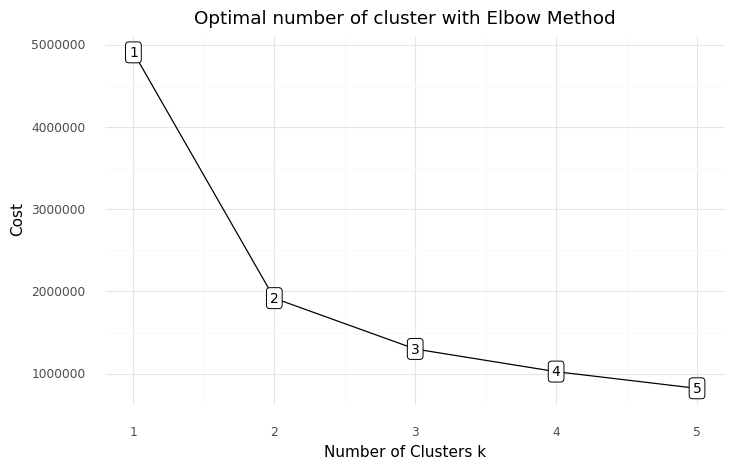

<ggplot: (8759658049685)>

In [ ]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 6):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(df_kp_Matrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

Este método tiende a reportar siempre un valor pequeño para la cantidad de cluster óptimos (2), los cuales suelen ser muy similares entre si en cuanto a su propensión a adquirir PF. 

Luego de cierto análisis, y estrechamente vinculado a lo observado en los Prácticos 1 y 2, es de esperar que se requiera una cantidad mayor de clusters para poder caracterizar o diferenciar grupos de clientes. 

Tomando las variables "age" y "Education_groups" identificó dos clusters como mejor opción, los cuales presentaban la siguiente probabilidad de contratar PF. 

                  y
	            0	       1		
Cluster 0	0.886377	0.113623

Cluster 1	0.883261	0.116739

In [34]:
# Fit con la cantidad de cluster optima encontrada (En este caso, aumenté la cantidad de cluster para ver si se encuentran diferencias en la propensión a contratar PF)
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit_predict(df_kp_Matrix, categorical = catColumnsPos)

array([0, 0, 3, ..., 0, 1, 0], dtype=uint16)

In [35]:
df_pp['kp'] = kprototype.labels_

In [36]:
pd.crosstab(df_pp.kp, df_pp.y, normalize='index')   

y,0,1
kp,,
0,0.838891,0.161109
1,0.918969,0.081031
2,0.856873,0.143127
3,0.904052,0.095948


In [37]:
df_pp['Segment'] = df_pp['kp'].map({0:'First', 1:'Second', 2:'Third',3:'Forth'})

In [38]:
# Cluster interpretation
df_pp.rename(columns = {'kp':'Total'}, inplace = True)
df_pp.groupby('Segment').agg(
    {
        'Total':'count',
        'education_groups': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'job_groups': lambda x: x.value_counts().index[0],
        'contact': lambda x: x.value_counts().index[0],
        'age': 'mean',
        'campaign': 'mean'
    }
).reset_index()

,Segment,Total,education_groups,marital,job_groups,contact,age,campaign
0,First,6238,Basic or less,married,Ingreso Cuenta Propia o Directivo,cellular,57.690766,2.219461
1,Forth,13007,University,married,Administrtivos,cellular,36.217729,2.234566
2,Second,10243,Basic or less,married,Operarios,cellular,45.784243,2.251391
3,Third,10606,University,single,Administrtivos,cellular,28.707901,2.211673


In [39]:
pd.crosstab(df_pp.Segment, df_pp.poutcome, normalize='index') 

poutcome,failure,nonexistent,success
Segment,,,
First,0.108849,0.833601,0.057550
Forth,0.109249,0.863612,0.027139
Second,0.090110,0.889290,0.020599
Third,0.114464,0.843108,0.042429


Cabe mencionar que en este caso forzamos la selección a 4 cluster ya que el método encontraba solo 2 y no resultaba suficiente para caracterizar de manera adecuada a la población de clientes tan diversa. Por tal razón, forzamos al método a utilizar 4 cluster y reportamos estos resultados. 

Encontramos algunas diferencias, aunque no de gran magnitud en la propensión a contratar PF. El grupo que presenta mayor propensión a contratar PF está conformado mayormente por clientes de bajo nivel educativo, casados, con una edad promedio de entre 57-58 años que tienen trabajos del tipo Cuenta Propia o Directivo. Este resultado es similar al encontrado por el método KMeans en la notebook principal. Asimismo, en este grupo se advierte la mayor proporción de clientes contactados anteriormente y el mayor porcentaje de éxitos en campañas previas.

Adicionalmente, el grupo que presenta la menor propensión a contratar PF está conformado mayormente por universitarios, casados, cuya edad promedio se encuentra en torno a los 36 años, y tienen trabajos de tipo administrativos.

### Conclusión

En esta notebook complementaria se presentaron algunos resultados extras del análisis que contempló las características personales del cliente, las cuales se presentaban por medio de variables categóricas, para el análisis de clusters. Si bien no se obtuvieron resultados concluyentes, lo arriba analizado permite aportar un poco más de información sobre la segmentación de clientes y las diferencias (o no diferencias mayormente) encontradas sobre las propensiones a contratar PF.